In [624]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from matplotlib import style
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_point
import geopandas as gpd
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import matplotlib.colors
import plotly.express as px
from plotly.subplots import make_subplots

# Overview

EDA exploration

I'd like to go snowboarding somewhere next year with a bunch of friend and I like to know how Kms are there by ski resort and few more thing to keep in mind. First of all, I want to work with data for knowing more about this niche.

My analysis is based by many countries, principaly between Europe and North America. Mostly, I have gotten one dataset from Kaggle and I scraped twice www.skiresort.info bewsite to get as much information as many 3000 ski resort. Now I want to explain how the distribution has been splited.

The data has details about Location, Altitude, Slope Kms, Price, and many quantifiers insight about, size, reliability of snow, Gastronomy and so.

# 1. Clustering Data

# 2. Data Cleaning 

   * ### Dealing with missing values
    
      *  Notes 

      * Other missing values 

# 3. Exploratory Data Analysis 

   ## 3.1  Worldwide

      * ### 1. Where are the highest ski resorts? 

      * ### 2. Distribution of Snow reability 

      * ### 3. Where are all ski resorts ?
    
   ## 3.2.  Europe vs North America 
      
      * ### 1. How Kms are distributed ?

      * ### 2. Distribution of Kms 

      * ### 3. Distribution of Kms by country for each level

      * ### 4. How each level are distributed by Continent  

      * ### 5. Show the prices along the countries 
      
      * ### 6. Correlation along all the feedbacks

      * ### 7. Distribution of Rates

      * ### 8. Distribution of Freeride along all Countries

# 4. Conclusion

   * ### Additional features I would like to see with this dataset 

   * ### Other questions that would be interesting to investigate. 

# 1. Clustering Data

I upload two doc with some information about how I have worked with webscrapping on the page I mentioned before.
- Avalanches
- Rates

In [625]:
#Here we upload first dataset from Kaggle
df1 = pd.read_csv('data/skiResort_2.csv',sep=';')
#Here upload the second dataset got from webscrapping on the page skiresort.info
free = pd.read_csv('data/Freeride_EU_rank.csv',index_col = 'Unnamed: 0')
#Here upload the third dataset got from webscrapping on the page skiresort.info
stars = pd.read_csv('data/reviewskiresort_EU.csv', index_col='Unnamed: 0')

In [626]:
#Get together both dataset from webscrapping on URL that i set it up before to get the same column 
df2 = pd.merge(stars,free, on= 'URL', how='outer')


In [627]:
#Get together last dataset to the main one by URL column 
skiresorts = pd.merge(df2,df1,  on='URL', how='outer')


# 2. Data Cleaning

    ###   Dealing with missing values
    
    A number of few missing values needs to be checked. In this case there were many NaN values in the rates columns, but I try to deleted as low as I could becasue I needed the majority. 
    
    Where I saw that column need to be filled i did it. I used the mean of three important rows, to get the mean rate for each Ski Resort, and I filled with random number between min, max of the mean of the same row. I did this step, just in case the row didn't contain anything.

In [628]:
#Fill in the NaN of the NameResort column with the values of the Resort Name column
skiresorts['NameResort'].fillna(skiresorts['Resort Name'], inplace=True)

#Fill in the NaN of the Freeride column with the old column.
skiresorts['Km Freeride'].fillna(skiresorts['Advanced skiers, freeriders '], inplace=True)

#Fill in the Nan from the conuntry column with those from the state column so that there are no nulls.
skiresorts['Country'].fillna(skiresorts['State/Province'], inplace=True)

#Fill the Rate column with the Ski resort ski data so that there are no null values.
skiresorts['Rate'].fillna(skiresorts['Ski resort size '].str.replace(',','.'), inplace=True)

#Fill in the State column with the Country data so that there are no null values
skiresorts['State/Province'].fillna(skiresorts['Country'], inplace=True)

#Fill in null values by 0,s
skiresorts.loc[:, ['Easy', 'Intermediate ', 'Difficult']] = skiresorts.loc[:, ['Easy', 'Intermediate ', 'Difficult']].fillna('0,0')



    ### Other missing values

In [629]:
#Delete the repeat column and I get the only ones i want for the analysis
skiresorts.drop(['Resort Name','Aerial tramway/reversible ropeway', 'Rope tow/beginner lift',
       'People mover', 'Combined installation (gondola and chair)',
       'Cog railway', 'Helicopter for Heli-skiing',
       'Snow caterpillars for Cat-skiing','Advanced skiers, freeriders ','Funicular',
       'Circulating ropeway/gondola lift', 'Chairlift',
       'T-bar lift/platter/button lift ', 'Sunkid Moving Carpet','Slope preparation ','Friendliness of staff ','Youth', 'Child'], axis = 1, inplace=True)

    ### Clustering the data I want for analysis

In [630]:
#Got only European values that these are we will work with 
skiresort_EU = skiresorts.drop(skiresorts[skiresorts['Continent']!='Europe'].index)
skiresort_EU.reset_index(drop='index',inplace=True)


    ### Replace , by . for get all of them to numeric values (int or float)

In [631]:
#Convert values , to . for working with them 
skiresort_EU['Adult'] = [float(x.replace(',','.')) for x in skiresort_EU['Adult']]
skiresort_EU['Altitude'] = [float(x.replace(',','.')) for x in skiresort_EU['Altitude']]
skiresort_EU['Easy'] = [float(x.replace(',','.')) for x in skiresort_EU['Easy']]
skiresort_EU['Intermediate '] = [float(x.replace(',','.')) for x in skiresort_EU['Intermediate ']]
skiresort_EU['Difficult'] = [float(x.replace(',','.')) for x in skiresort_EU['Difficult']]
skiresort_EU['Rate'] = pd.to_numeric(skiresort_EU['Rate'])

columns = ['Ski resort size ',
       'Slope offering, variety of runs ', 'Lifts and cable cars ',
       'Snow reliability ', 'Access, on-site parking ',
       'Orientation (trail map, information boards, sign-postings) ',
       'Cleanliness and hygiene ', 'Environmentally friendly ski operation ',
       'Mountain restaurants, ski huts, gastronomy ', 'Après-ski ',
       'Accommodation offering directly at the slopes and lifts ',
       'Families and children ', 'Beginners ', 'Snow parks ',
       'Cross-country skiing and trails ']

#Replace , by . 
skiresort_EU[columns] = skiresort_EU[columns].apply(lambda x: x.str.replace(',','.'))

In [632]:

#Convert to float all columns whic are number and leave NaN which not allow to get convert themself
def convert_to_numeric(columns):
       skiresort_EU[columns] = skiresort_EU[columns].apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

convert_to_numeric(['Ski resort size ',
       'Slope offering, variety of runs ', 'Lifts and cable cars ',
       'Snow reliability ', 'Access, on-site parking ',
       'Orientation (trail map, information boards, sign-postings) ',
       'Cleanliness and hygiene ', 'Environmentally friendly ski operation ',
       'Mountain restaurants, ski huts, gastronomy ', 'Après-ski ',
       'Accommodation offering directly at the slopes and lifts ',
       'Families and children ', 'Beginners ', 'Snow parks ',
       'Cross-country skiing and trails ','Km Freeride'])

    ### Calculate all the currency from diferent countries

In [633]:
def multiply(row):
    """
    This funtion multiply each value form Adult column by each value itself, and get as result 
    Euros currency to opeate with them.

    In addition, return values already multiply and add them to same column 
    """
    if row['Currency'] == 'Czech koruna':
        return row['Adult'] * 0.042
    elif row['Currency'] == 'Norwegian krone':
        return row['Adult'] * 0.093
    elif row['Currency'] == 'Polish zloty':
        return row['Adult'] * 0.21
    elif (row['Currency'] == 'Swedish krona') & (row['Adult'] > 80):
        return row['Adult'] * 0.089
    elif row['Currency'] == 'UK Pound':
        return row['Adult'] * 1.13
    elif row['Currency'] == 'Bulgarian Lev':
        return row['Adult'] * 0.51
    elif row['Currency'] == 'Romanian leu':
        return row['Adult'] * 0.20
    elif row['Currency'] == 'Bosnia convertible mark':  
        return row['Adult'] * 0.006
    elif row['Currency'] == 'Icelandic krona':
        return row['Adult'] * 0.0065
    elif row['Currency'] == 'Hungarian forint':
        return row['Adult'] * 0.0024
    else:
        return row['Adult']

        
skiresort_EU['Adult'] = skiresort_EU.apply(multiply, axis=1)

    ### Clustering data again for getting cleaner than before.

In [634]:
#Replace all values by European euro for deleting in a few steps

skiresort_EU = skiresort_EU.replace({
    'Swiss Franc': 'European Euro',
    'Norwegian krone': 'European Euro',
    'Czech koruna': 'European Euro',
    'Polish zloty': 'European Euro',
    'Swedish krona': 'European Euro',
    'UK Pound': 'European Euro',
    'Romanian leu': 'European Euro',
    'Bosnia convertible mark': 'European Euro',
    'Icelandic krona': 'European Euro',
    'Hungarian forint': 'European Euro',
    'Bulgarian Lev': 'European Euro',
    '-': 'European Euro'
})
#He I have only de European Euro Currency I wanted, just for delete easily 
skiresort_EU = skiresort_EU.drop(skiresort_EU[skiresort_EU['Currency']!='European Euro'].index)
skiresort_EU.reset_index(drop='index',inplace=True)


In [635]:
#Delete the rows which contains NaN values in Rate column, because i checked also, and those values don't have infomation on the website, so we don't need for analisys.
skiresort_EU = skiresort_EU.drop(skiresort_EU[pd.isnull(skiresort_EU['Rate'])].index)
skiresort_EU.reset_index(drop='index', inplace=True)

        ### Filling NaN values

In [636]:
#Get a column with mean values between three important columns of each ski resort, which have number to calculate with themself to get the mean. That mean is reliable becasue those values follow the rate of Ski Resort
skiresort_EU['mean'] = skiresort_EU.apply(lambda row: row[14:17].mean(), axis=1)

#New column with sum of three difficulties of slopes
skiresort_EU['Kms'] = skiresort_EU.apply(lambda row: row[9:12].sum(),axis=1)

    ### Fill the NaN values with random values in each column of every row with random values.

In [637]:
# Iterate by every column of this variable and I apply in each NaN value a random number between mean- 0.5 and mean + 0.5.
columns2 = ['Snow reliability ', 'Access, on-site parking ',
       'Orientation (trail map, information boards, sign-postings) ',
       'Cleanliness and hygiene ', 'Environmentally friendly ski operation ',
       'Mountain restaurants, ski huts, gastronomy ', 'Après-ski ',
       'Accommodation offering directly at the slopes and lifts ',
       'Families and children ', 'Beginners ', 'Snow parks ',
       'Cross-country skiing and trails ']


for column in columns2:
    mean = skiresort_EU.iloc[:,14:17].mean().mean()
    skiresort_EU[column] = skiresort_EU[column].apply(lambda x: np.random.uniform(mean-0.5, mean+0.5) if np.isnan(x) else x)

In [638]:
#Drop NaN values
skiresort_EU = skiresort_EU.drop(skiresort_EU[pd.isnull(skiresort_EU['Beginners '])].index)

    ### Change the name of columns and delete

In [639]:
#Change the name of column for reading them easily
skiresort_EU.rename(columns = {'NameResort':'Resort Name', 'Stars':'Freeride', 'Km Freeride':'Freeride Kms', 'Cross-country skiing and trails ':'Cross-Country',
                            'Mountain restaurants, ski huts, gastronomy ':'Restaurants and Gastronomy','Orientation (trail map, information boards, sign-postings) ':'Trail maps and signs',
                            'Slope offering, variety of runs ':'Slope offering','Lifts and cable cars ':'Lifts and gondolas','Ski resort size ':'Ski resort size',
                                'Snow reliability ':'Snow reliability','Access, on-site parking ':'On-site parking','Cleanliness and hygiene ':'Cleanliness and hygiene',
                                'Environmentally friendly ski operation ':'Environmentally friendly ski operation','Après-ski ':'Apres-ski',
                                'Families and children ':'Families and children','Beginners ':'Beginners','Snow parks ':'Snow parks','Rate':'Ski Resort Rate','Adult':'Price'},inplace=True)

#Delete the columns I dont need
skiresort_EU.drop(['Accommodation offering directly at the slopes and lifts ','URL','mean','Currency'],axis=1,inplace=True)

In [640]:
#Change the order of the Columns 
new_reloc = ['Resort Name','Continent', 'Country', 'State/Province','Ski Resort Rate','Altitude', 'Easy',
       'Intermediate ', 'Difficult','Kms', 'Price','Freeride', 'Freeride Kms','Ski resort size',
       'Slope offering', 'Lifts and gondolas', 'Snow reliability',
       'On-site parking', 'Trail maps and signs', 'Cleanliness and hygiene',
       'Environmentally friendly ski operation', 'Restaurants and Gastronomy',
       'Apres-ski', 'Families and children', 'Beginners', 'Snow parks',
       'Cross-Country']

skiresort_EU = skiresort_EU.reindex(columns = new_reloc).round(2).reset_index(drop='index')

    ### Fill NaN values in price Column

In [641]:
#Apply for 0 values in Price column a random number between 60,90 if Rate is more than 3 and 15,27 between is Rate is lower than 3
random.seed(200)
def randomizar(row):
    if row['Ski Resort Rate'] >= 3 and row['Price'] == 0:
        return random.uniform(60, 90)
    elif row['Ski Resort Rate'] < 3 and row['Price'] == 0:
        return random.uniform(15, 27)
    else:
        return row['Price']

skiresort_EU['Price'] = skiresort_EU.apply(randomizar, axis=1)


# 2. Exploratory Data Analisys


    ##Upload all dataset we are going to work with

In [642]:
# Open Csv that it is already cleaned for analysis.
ski_resorts = pd.read_csv('data/skiAmEU.csv', index_col='Unnamed: 0')
ski_resorts.replace({'Resort Name':{'St. Anton/St. Christoph/Stuben/Lech/Zürs/Warth/Schröcken – Ski Arlberg':'Ski Arlberg'}},inplace=True)


In [643]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

In [644]:
#Open another dataset with all data from every Continent
skiresorts_pure = pd.read_csv('/Users/migueldefrutos/Documents/Bootcamp/Data_Bridge /Alumno /ds_thebridge_11_22/Entregas/GitEDA/EDA-/src/data/Skiworldwide.csv',index_col = 'Unnamed: 0')
skiresorts_pure.replace({'Continent':{'Australia and Oceania':'Oceania','Russia':'Asia'}}, inplace = True)
skiresorts_pure.replace({'NameResort':{'St. Anton/St. Christoph/Stuben/Lech/Zürs/Warth/Schröcken – Ski Arlberg':'Ski Arlberg'}},inplace=True)


## Where are all Ski Resorts?

Lets see how the distributio about ski resort worldwide going on.

## Worldwide

1. First of all, let's which is the highest resort in the world

In [645]:
highest_skyresort = skiresorts_pure[['NameResort','Continent','Altitude','Snow reliability ']].sort_values(by = 'Altitude', ascending=False)[0:20]
Nombres = ['Himachal', 'Huascaran Pasto','Jade Dragon', 'Powder South','Tien shan','Gulmarg','Shangri','Breckenridge','Matterhorn','Loveland','Tochal','Aiguille du midi chamonix','Mt Elbrus','Telluride','Snowmass','Taos','Arapahoe Basin','Silverton Mountain','Copper Mountain','Arpa los andes']
for x in range(len(list(highest_skyresort['NameResort'].values))):
    highest_skyresort['NameResort'].values[x] = Nombres[x]

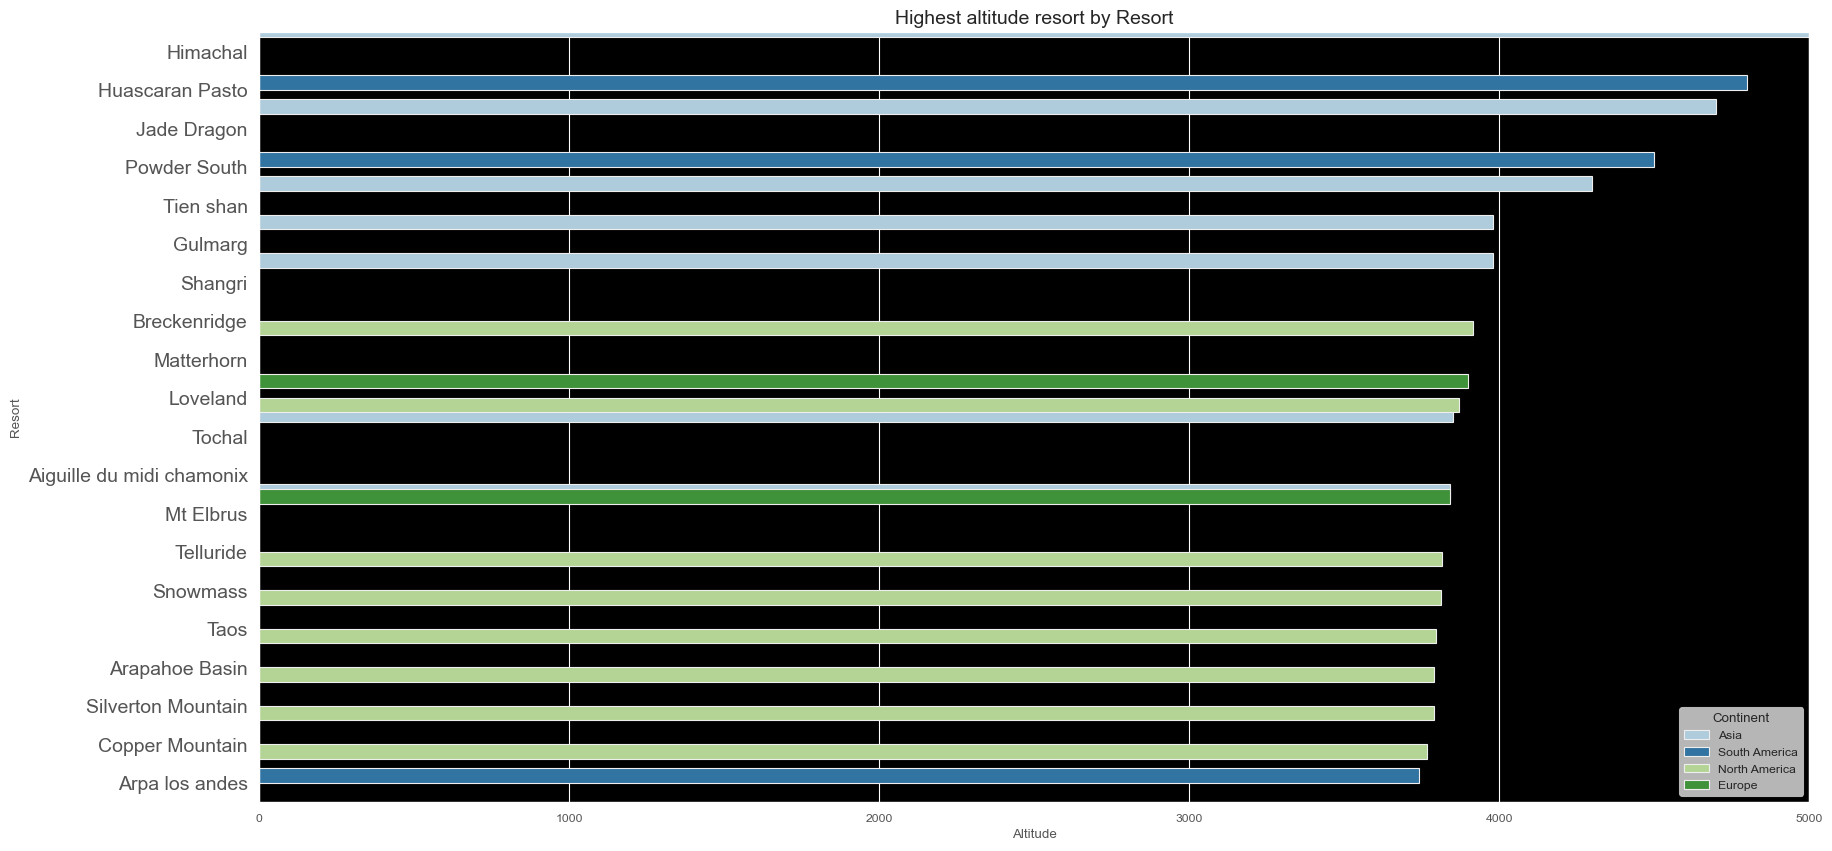

In [691]:
#We see the highest ski resort
plt.figure(figsize=(20,10))
ax = sns.barplot(y="NameResort", x="Altitude" ,data=highest_skyresort, palette="Paired", hue = 'Continent' , width=1.5, zorder= 1)
ax.set_facecolor('black')
ax.set_xlim(0,5000)
plt.xlabel('Altitude')
plt.ylabel('Resort')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.title('Highest altitude resort by Resort', loc='Center', fontsize=14)
plt.show()

Despite Asia and Sout America has most of the highest Skir resort, mos of them are heliski, we can consideres as no resort.

 2. But now let's comparate how the reviews are distribute over the world about quality of Snow

In [647]:
# We can see how the distribution of reliability of snow works, North America has better snow than Europe by mean, but we had to deleted some NaN values
ski_reliability = skiresorts_pure[['NameResort','Continent','Country','Altitude','Snow reliability ', 'Slope offering, variety of runs ','latitude','longitude']].sort_values('Snow reliability ', ascending=False)
ski_reliability[ski_reliability['Snow reliability '].isnull()].head(40)
ski_reliability.dropna(subset=['Snow reliability '], inplace=True)


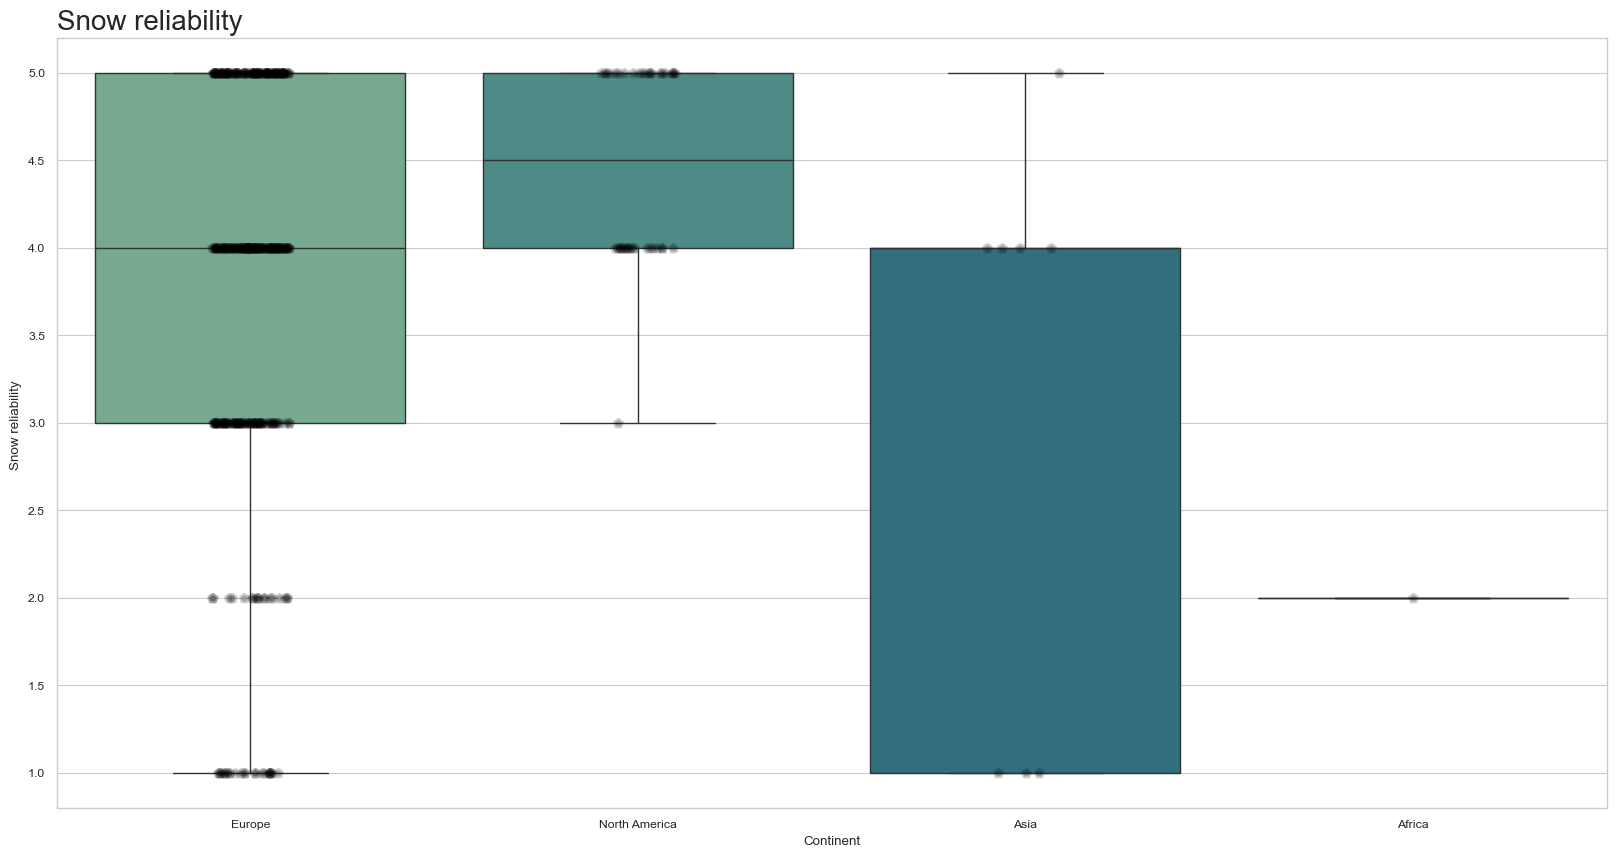

In [648]:
# We can see how the distribution of reliability of snow going on, North America has better snow than Europe by mean
plt.figure(figsize = (20,10))
sns.set_style('whitegrid')
ax = sns.boxplot(x='Continent', y="Snow reliability ", data=ski_reliability, palette = 'crest', linewidth= 1)
sns.stripplot(data=ski_reliability, x="Continent", y="Snow reliability ", color= 'black', marker="p", linewidth=3, alpha=.2,)
plt.title('Snow reliability', loc="left", fontsize = 20);

though we considered this analysis about snow not enough for some lefts values, in many Countries, if we would have have more values, it would have been more valuable.

 3. Where are all ski resort ?

In [649]:
#Number of ski resort by country mundialy
skiresorts_country = skiresorts_pure.groupby(['Continent','Country'])[['NameResort']].count().sort_values(by = 'NameResort',ascending=False)

#Get the first 5 Country with the most values of resorts
skiresorts_country['Percent'] = round((skiresorts_country['NameResort']/skiresorts_country['NameResort'].sum())*100,2)
print('Los 5 principales Paises del mundo reprentan el', skiresorts_country['Percent'][0:5].sum(),'%')

Los 5 principales Paises del mundo reprentan el 47.53 %


In [650]:
skiresorts_country

NameResort  Percent
Continent     Country                                          
Europe        Germany                              715    13.07
Asia          Japan                                597    10.92
North America USA                                  521     9.53
Europe        Austria                              433     7.92
              Switzerland                          333     6.09
              Czech Republic                       301     5.50
              Italy                                291     5.32
North America Canada                               289     5.28
Europe        Poland                               254     4.64
              France                               251     4.59
Asia          China                                133     2.43
Europe        Slovakia                             126     2.30
              Sweden                               118     2.16
              Norway                               112     2.05
              Romania                               93     1.70
              Finland                               82     1.50
              United Kingdom                        80     1.46
              Slovenia                              49     0.90
              Ukraine                               48     0.88
Oceania       New Zealand                           40     0.73
Asia          Turkey                                36     0.66
Europe        Spain                                 36     0.66
              Russia                                36     0.66
              Serbia                                25     0.46
              Greece                                24     0.44
Asia          India                                 22     0.40
              Iran                                  21     0.38
              South Korea                           21     0.38
              Kyrgyzstan                            21     0.38
Europe        Bulgaria                              20     0.37
South America Argentina                             19     0.35
              Chile                                 18     0.33
Europe        Netherlands                           18     0.33
              Bosnia and Herzegovina                16     0.29
Oceania       Australia                             15     0.27
Europe        Hungary                               14     0.26
              Latvia                                12     0.22
              Belgium                               12     0.22
              Iceland                               11     0.20
Asia          Central Russia                        11     0.20
Europe        Lithuania                             11     0.20
North America Greenland                             11     0.20
Europe        Croatia                               10     0.18
Asia          Northwest Russia                       9     0.16
Europe        Macedonia                              8     0.15
Asia          North Caucasus                         8     0.15
Europe        Denmark                                8     0.15
Asia          Ural Federal District                  8     0.15
Africa        Morocco                                7     0.13
Asia          Lebanon                                7     0.13
              Siberia                                7     0.13
              United Arab Emirates                   6     0.11
              Volga Federal District                 6     0.11
              Georgia                                6     0.11
              Southern Russia                        5     0.09
Europe        Estonia                                5     0.09
Asia          Turkmenistan                           5     0.09
              Kazakhstan                             5     0.09
Europe        Montenegro                             4     0.07
              Belarus                                4     0.07
Asia          Uzbekistan                             4     0.07
Africa      

In [651]:
skiresorts_country.reset_index(inplace=True)
print('Europa respresenta el' ,skiresorts_country[skiresorts_country['Continent'] == 'Europe']['Percent'].sum().round(2), '%', 'frente al resto del Mundo')

Europa respresenta el 65.3 % frente al resto del Mundo


In [652]:
#SUM of percent by resort from every country
skiresort_continent = skiresorts_country.groupby('Continent')['Percent'].sum()

In [653]:
#Create a pie chart with suma of percent by Continent
continent = px.pie(skiresort_continent, values=skiresort_continent.values, names=skiresort_continent.index,color_discrete_sequence=px.colors.sequential.Blues,template = 'plotly_dark')
continent.update_traces(textposition='inside', textinfo='percent+label',pull=[0, 0,0, 0,0,0,0,0,0,0,0,0,0])
continent.update_layout(title_text='Resorts by Continents', width=800,height=600)
continent.show()

In [654]:
# See the number of ski resort there are splitted by Continent
pd.pivot_table(skiresorts_country, values = 'NameResort', index='Continent', aggfunc=np.sum).sort_values('NameResort', ascending=False)

,NameResort
Continent,
Europe,3571
Asia,967
North America,822
Oceania,55
South America,40
Africa,14


## Europe vs North America

In [655]:
kmsby_continent = skiresorts_pure.groupby('Continent')[['Easy','Intermediate ','Difficult','Km Freeride','Total Kms']].sum().sort_values(by = 'Total Kms',ascending = False)
kmsby_continent.reset_index(inplace=True)

In [656]:
df_melt = kmsby_continent.melt(id_vars=['Continent'], value_vars=['Easy', 'Intermediate ', 'Difficult','Km Freeride',
       'Total Kms'], var_name='New Column')
df_melt.sort_values(by='New Column', ascending=False)

,Continent,New Column,value
29,Africa,Total Kms,18.0
24,Europe,Total Kms,36316.0
28,South America,Total Kms,699.0
27,Oceania,Total Kms,839.0
26,Asia,Total Kms,4037.0
25,North America,Total Kms,15010.0
20,Asia,Km Freeride,11.0
21,Oceania,Km Freeride,0.0
22,South America,Km Freeride,0.0
23,Africa,Km Freeride,1.0


 1. How the Kms are distributed along these Countries 

In [657]:
# See the distribution of Kms by Countries 

fig = go.Figure()

fig.add_trace(go.Bar(
    x=kmsby_continent.Continent,
    y=kmsby_continent.Easy,
    name='Green',
    marker_color='lightgreen'))

fig.add_trace(go.Bar(
    x=kmsby_continent.Continent,
    y=kmsby_continent['Intermediate '],
    name='Blue', marker_color='skyblue'))

fig.add_trace(go.Bar(
    x=kmsby_continent.Continent,
    y=kmsby_continent['Difficult'],
    name='Black',
    marker_color='grey',))

fig.add_trace(go.Bar(
    x=kmsby_continent.Continent,
    y=kmsby_continent['Km Freeride'],
    name='DoubleBlack',
    marker_color='indianred',text=kmsby_continent['Total Kms'],
    textposition='auto'))

#fig.add_trace(go.Scatter(
#    x=kmsby_continent.Continent,
#    y=kmsby_continent['Total Kms'],
#    text=(kmsby_continent['Total Kms']),
#    textposition='top center',
#    mode='text',
#    showlegend=False
#))

fig.update_layout(barmode='stack', xaxis_tickangle=-30, title = 'Kms of snow slopes by Continents',width=1000,height=500,template = 'plotly_dark')
fig.show()

2. We can se the distribution of Ski Resort along America and Europe

In [658]:
#Number of Resort by country 
resort_bycountry = ski_resorts.groupby(['Continent','Country'],as_index=False)[['Resort Name']].count().sort_values(by='Resort Name', ascending=False)
resort_bycountry = resort_bycountry.rename(columns = {'Resort Name':'Count'})

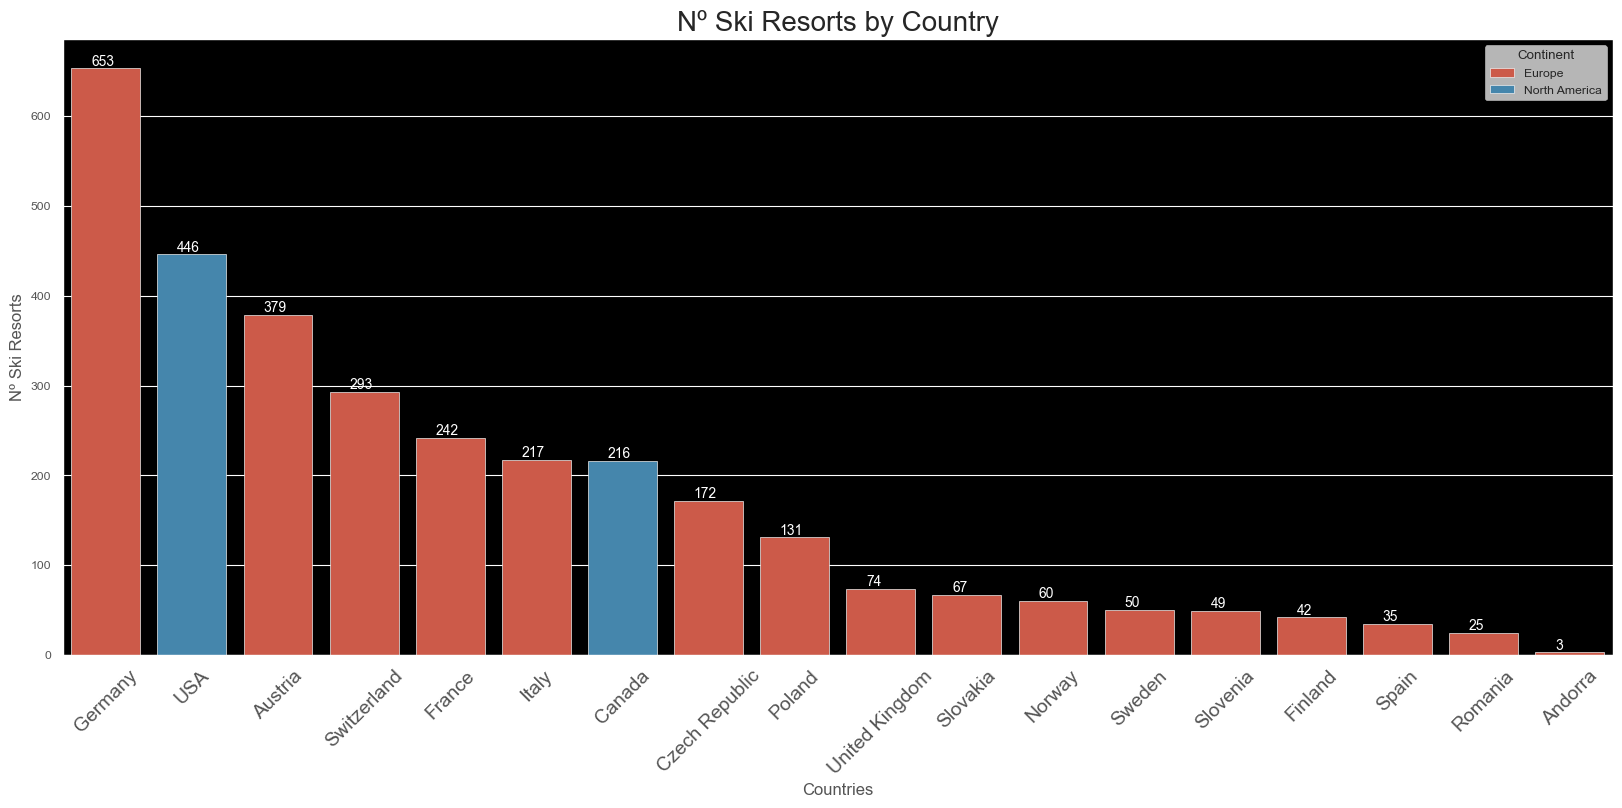

In [659]:
#Show the number of ski resort there are in each Country
style.use('ggplot')
plt.figure(figsize=(20,8))
barplot=sns.barplot(x=resort_bycountry['Country'],
            y=resort_bycountry['Count'],
           errorbar=None,hue= resort_bycountry['Continent'], width=0.8, dodge=False);

for bar in barplot.patches:
    # print(bar.get_height())
    altura_b = bar.get_height()
    # print(bar.get_x())
    x_b = bar.get_x()
    # print(bar.get_width())
    w_b = bar.get_width()
    if not pd.isna(altura_b):
        plt.text(x_b + w_b/3.5 , altura_b, int(altura_b), va="bottom", color='white')

barplot.set(xlabel='Countries', ylabel='Nº Ski Resorts');
barplot.set_facecolor('black')
plt.title('Nº Ski Resorts by Country', fontsize = 20)
plt.xticks(rotation =45, fontsize = 14);


 3. We can compare Kms level slopes between Countries

In [660]:
#Kms slopes by country 
Kms = ski_resorts.groupby('Country')[['Easy','Intermediate ','Difficult']].sum()
Kms['Total'] =  Kms.apply(lambda row:row.sum(),axis=1)


In [661]:
#We draw a graphs with diferent levels each pie ,and inside splitted by countries

fig = make_subplots(rows=2, cols=3, specs=[[{'type':'pie'}, {'type':'pie'},{'type':'pie'}],[{'type':'pie'},{'type':'pie'},{'type':'pie'}]],subplot_titles=['Easy slopes', 'Intermediate Slopes','Difficult Slopes','','Total'])

fig.add_trace(go.Pie(labels = Kms.index, values=Kms.Easy.values, ),1,1)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0, 0, 0.2, 0,0,0,0,0,0,0,0,0,0])

fig.add_trace(go.Pie(labels = Kms.index, values=Kms['Intermediate '].values),1,2)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0, 0, 0.2, 0,0,0,0,0,0,0,0,0,0])

fig.add_trace(go.Pie(labels = Kms.index, values=Kms['Difficult'].values),1,3)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0, 0, 0.2, 0,0,0,0,0,0,0,0,0,0])

fig.add_trace(go.Pie(labels = Kms.index, values=Kms['Total'].values),2,2)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0, 0, 0.2, 0,0,0,0,0,0,0,0,0,0])

fig.update_layout(title_text='Kms by Countries', width=1100,height=900, template = 'plotly_dark')

fig.show()

4. See the different of density seeing diferent level split by Continent

In [662]:
dificulties  = ski_resorts.groupby(['Resort Name','Continent'])[['Easy','Intermediate ','Difficult']].sum()
dificulties.reset_index(inplace=True)
dificulties_melt = dificulties.melt(id_vars='Continent', value_vars=['Easy', 'Intermediate ', 'Difficult'], var_name = 'dificulties', value_name = 'kms')


In [663]:
dificulties_melt

,Continent,dificulties,kms
0,Europe,Easy,17.3
1,Europe,Easy,42.0
2,Europe,Easy,2.8
3,Europe,Easy,60.0
4,Europe,Easy,30.6
...,...,...,...
9457,Europe,Difficult,0.0
9458,Europe,Difficult,1.2
9459,Europe,Difficult,0.0
9460,Europe,Difficult,1.0


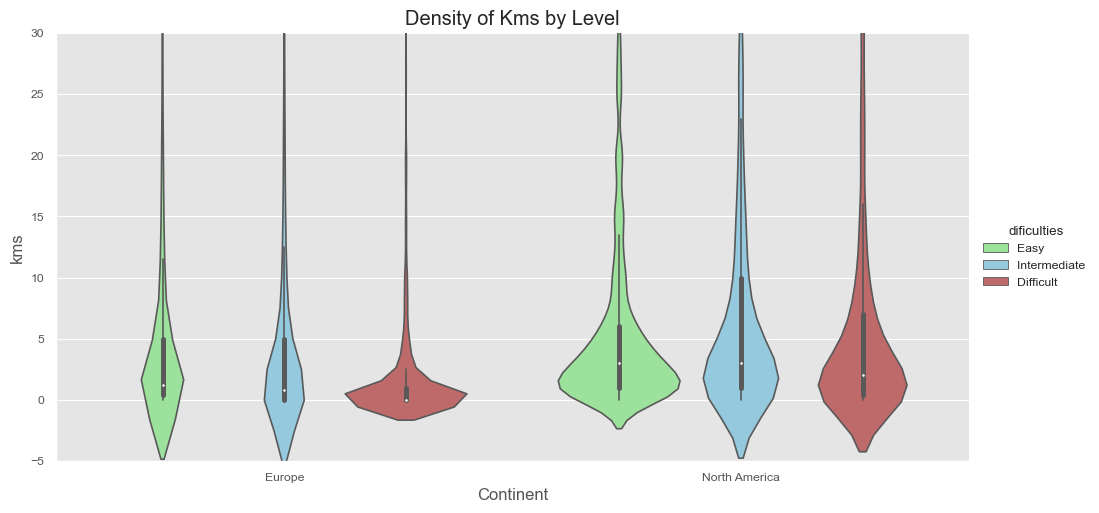

In [664]:
my_pal = ['lightgreen','skyblue','indianred' ]
x = sns.catplot(x="Continent",
            y="kms",
            hue="dificulties",
            kind= 'violin',
            data=dificulties_melt,
            height=5,
            aspect=2, bw= .15, palette= my_pal );

plt.title('Density of Kms by Level')
sns.set_context("paper", rc={"figure.facecolor":"white"})

plt.ylim(-5,30);

5. Show the prices along the countries 

In [665]:
#See outliers in price by different countries, mean of the prices, how the distribution of the price going on
price = ski_resorts.groupby(['Resort Name','Country'])[['Adult']].mean().sort_values('Adult',ascending=False)
price.reset_index(inplace=True)

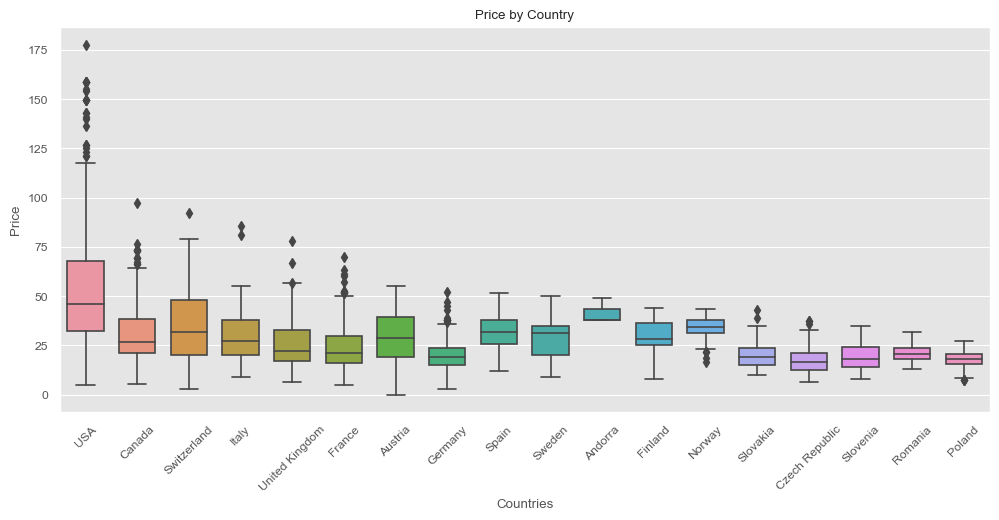

In [666]:
plt.figure(figsize= (12,5))
sns.boxplot(x='Country' ,y= 'Adult', data= price,dodge=False,width=0.7)
plt.xticks(rotation = 45)
plt.title('Price by Country')
plt.ylabel('Price')
plt.xlabel('Countries');


6. Correlation along all the feedbacks

In [667]:
#Correlations between diferent variables of ski resorts.
corre = ski_resorts[['Continent','Ski Resort Rate', 'Ski resort size', 'Kms', 'Easy','Intermediate ', 'Adult','Slope offering','Snow reliability','Snow parks','Freeride','Families and children','Restaurants and Gastronomy']].corr()

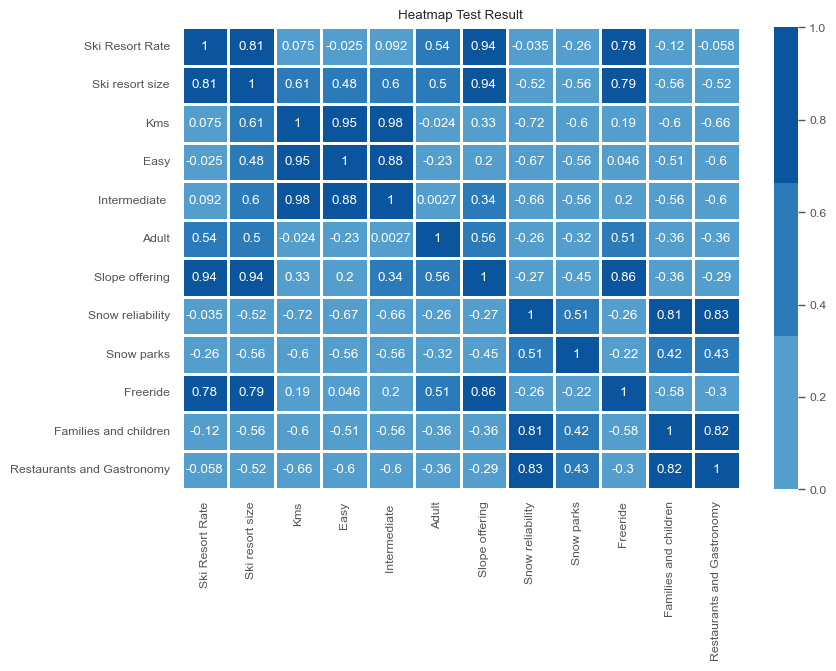

In [668]:

plt.figure(figsize=(9,6))
mask = np.zeros_like(corre)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corre.corr(),vmin=0, vmax=1, center=0,
            cmap= sns.color_palette("Blues"), linewidths=.9, annot=True);

plt.title('Heatmap Test Result')
plt.show()

        ##Pairplot between some variable, which are related themselves

In [669]:
df4 = ski_resorts[['Continent','Ski Resort Rate', 'Ski resort size','Slope offering','Freeride']]


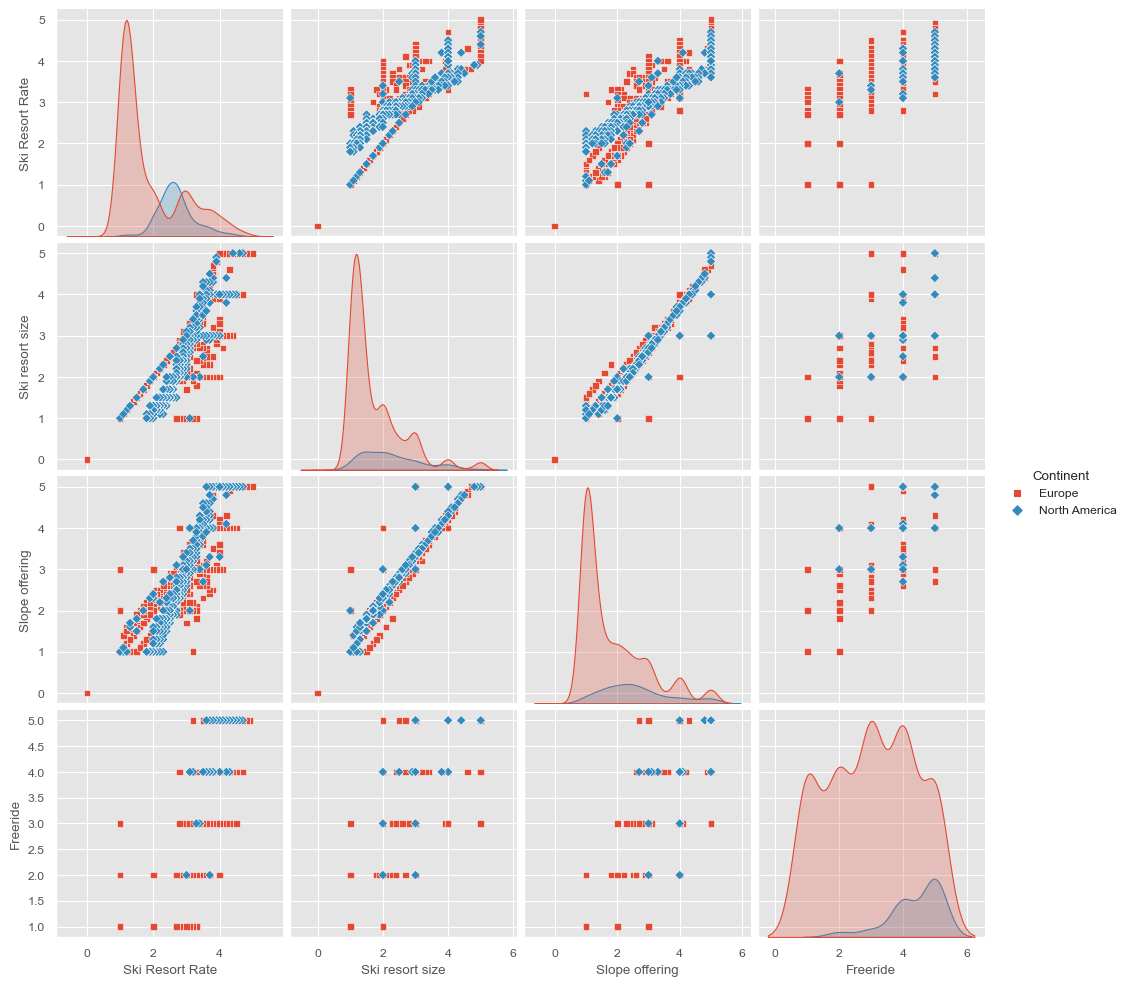

In [670]:
sns.pairplot(df4, hue = 'Continent',markers=["s", "D"]);

7. Distribution of Rates

In [671]:
# Great advice to know how the rates going on, which is very important to know which are the thought of the people
top = ski_resorts[ski_resorts['Country'].isin(['Italy','USA','France','Austria','Switzerland'])]
top = top.groupby(['Resort Name','Country'])['Freeride','Ski Resort Rate'].sum().sort_values('Ski Resort Rate', ascending=False)
top.reset_index(inplace=True)

/Users/migueldefrutos/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [672]:
ski_resorts[ski_resorts['Freeride Kms'] > 100]

,Resort Name,Continent,Country,State/Province,Ski Resort Rate,Altitude,Easy,Intermediate,Difficult,Kms,Adult,Freeride,Freeride Kms,Ski resort size,Slope offering,Lifts and gondolas,Snow reliability,On-site parking,Trail maps and signs,Cleanliness and hygiene,Environmentally friendly ski operation,Restaurants and Gastronomy,Apres-ski,Families and children,Beginners,Snow parks,Cross-Country
3,Ski Arlberg,Europe,Austria,Tyrol (Tirol),4.8,2811.0,132.0,123.0,50.0,305.0,53.0,5.0,200.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0


In [673]:

fig = px.box(top, y= 'Ski Resort Rate', color="Country",facet_col="Country",
             boxmode="overlay", points='all',color_discrete_sequence=px.colors.diverging.delta)
fig.update_traces(marker=dict(size=3))
fig.update_layout(plot_bgcolor='azure',paper_bgcolor='azure', title = 'Top Rates')

fig.show()

8. Distribution of Freeride along all Countries

In [674]:
#Generate a new dataframe with these values 
freeride = ski_resorts.groupby(['Resort Name','Country','Continent'])[['Freeride Kms']].sum()
freeride.reset_index(inplace =True)
NA = freeride[freeride['Continent'].isin(['North America',])]
EU = freeride[freeride['Continent'].isin(['Europe'])]

In [675]:

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]],subplot_titles=['Europe', 'North America'])

fig.add_trace(go.Pie(labels = EU['Country'], values=EU['Freeride Kms']),1,1)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0.2, 0, 0, 0,0,0,0,0,0,0,0,0,0])

fig.add_trace(go.Pie(labels = NA['Country'], values=NA['Freeride Kms']),1,2)
fig.update_traces(textposition='inside', textinfo='percent+label',insidetextorientation='radial',pull=[0, 0.2])

fig.update_layout(title_text='Freeride Kms',template = 'plotly_dark')

    ## We will see which are the best ski resort for Freeride between two Countries.

In [677]:
#Now with the last ones are the greatest
TOP = freeride[freeride['Country'].isin(['Austria','USA'])]


In [687]:
fig = go.Figure()
fig = px.sunburst(TOP, path=['Country', 'Resort Name'], values='Freeride Kms',template = 'plotly_dark')
fig.update_layout(width=800, height=600, title = 'Top Freeride')
fig.show()